In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import clone_model

from dm_control import suite
from dm_control import viewer
import time
import random 

from matplotlib import pyplot as plt

In [2]:
def convert_observation(obs):
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = np.array([])
    for sublist in list1:
        list2 = np.append(list2, sublist)
    return list2.reshape([1,25])

In [3]:
# parameters and models from : https://arxiv.org/pdf/1801.00690.pdf
# https://spinningup.openai.com/en/latest/algorithms/ddpg.html
# losses: https://books.google.ru/books?id=O0vODwAAQBAJ&pg=PA521&lpg=PA521&dq=ddpg+critic+loss&source=bl&ots=IpfwYeBefs&sig=ACfU3U1hyUgfCDUmU3SeIn5Nm4iNwnC8Ow&hl=ru&sa=X&ved=2ahUKEwjbxYOeqdLpAhWMtYsKHf_YCWsQ6AEwCXoECAoQAQ#v=onepage&q=ddpg%20critic%20loss&f=false

In [4]:
tf.keras.backend.set_floatx('float64')


class Agent:
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.01
        self.action_dim = len(action_spec.minimum)
        self.action_spec = action_spec
        self.input_size = 5
        self.noise_scale = 1.0
        
        
        self.critic_opt = tf.optimizers.Adam(1e-3)
        self.actor_opt = tf.optimizers.Adam(1e-3)        

        # create critic model:      
        action_input = tf.keras.Input(shape=(self.action_dim,), name='action')
        observation_input = tf.keras.Input(shape=self.input_size, name='state')
        flattened_observation = tf.keras.layers.Flatten()(observation_input)
        x = tf.keras.layers.Dense(400)(flattened_observation)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Concatenate()([x, action_input])
        x = tf.keras.layers.Dense(300)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dense(1)(x)
        x = tf.keras.layers.Activation('linear')(x)
        critic = tf.keras.Model(inputs=[action_input, observation_input], outputs=x)
        self.critic_model = critic

        # create actor model:
        actor = tf.keras.Sequential()
        actor.add(tf.keras.layers.Input(shape = self.input_size, name='observation_input'))
        actor.add(tf.keras.layers.Dense(400))
        actor.add(tf.keras.layers.Activation('relu'))
        actor.add(tf.keras.layers.Dense(300))
        actor.add(tf.keras.layers.Activation('relu'))
        actor.add(tf.keras.layers.Dense(self.action_dim))
        actor.add(tf.keras.layers.Activation('tanh'))
        self.actor_model = actor

        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_critic_model.compile(optimizer='sgd', loss='mse')
        
        self.target_actor_model = clone_model(self.actor_model)
        self.target_actor_model.compile(optimizer='sgd', loss='mse')
        
        self.actor_model.compile(optimizer='sgd', loss='mse')
        self.critic_model.compile(optimizer=self.critic_opt, loss='mse')
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)[0]
        action = action + self.noise_scale*np.random.normal(0,1,size = self.action_dim)
        action = np.clip(action, -1.0, 1.0)
        return action
           
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1e6:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-int(0.9e6):]
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else:            
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if self.memory["done"].shape[0]>=self.batch_size:
            # get batch
            idxs = random.sample(range(0, self.memory["done"].shape[0]), self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": np.squeeze(self.memory["action"][idxs]), 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.target_actor_model(batch["new_state"])})
                      
            y = batch["reward"].reshape(self.batch_size,1) + \
                (self.discount_rate*(1-batch["done"])).reshape(self.batch_size,1)*target_q
           
            # update critic

            self.critic_model.train_on_batch({"state": batch["state"], "action": batch["action"]}, y)

            # update actor policy
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], 
                                       "action": self.actor_model(batch["state"])})
                actor_loss = - tf.reduce_mean(q)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))

                        
            # update networks
            self.target_critic_model.set_weights((1.0-self.tau) * np.array(self.target_critic_model.get_weights()) + \
                                          self.tau*np.array(self.critic_model.get_weights()))
            self.target_actor_model.set_weights((1.0-self.tau) * np.array(self.target_actor_model.get_weights()) + \
                                         self.tau*np.array(self.actor_model.get_weights()))
            
            self.noise_scale*=0.99



In [5]:
def save_models(agent):
    agent.critic_model.save('critic_model_snake.h5')
    agent.actor_model.save('actor_model_snake.h5')
    agent.target_critic_model.save('target_critic_model_snake.h5')
    agent.target_actor_model.save('target_actor_model_snake.h5')
    
def train_model(env, n_iterations, batch_size, discount_rate):
    scores = np.array([])
    last_rewards = np.array([])
    first_rewards = np.array([])
    action_spec = env.action_spec()
    agent = Agent(action_spec)
    start = time.time()

    for iteration in range(n_iterations):       
        if (iteration+1) % 50 == 0:
            save_models(agent)
            np.savetxt('scores.csv', scores, fmt='%1.2f')
            np.savetxt('last_rewards.csv', last_rewards, fmt='%1.2f')
            np.savetxt('first_rewards.csv', first_rewards, fmt='%1.2f')
            
            print("{:10.3f} minutes remaining".format((time.time()-start)/60))
            plt.figure(figsize=(15,7))
            plt.grid()
            x=list(range(len(scores)))
            plt.plot(x, scores)

            plt.title("Learning curves: score per iteration")
            plt.ylabel("Reward")
            plt.xlabel("Iteration number")
            plt.show()

        time_step = env.reset()  
        obs = convert_observation(time_step.observation)

        game_score = 0
        while not time_step.last():       
            # get action:
            action = agent.sample_action(obs)
            # make action:
            time_step = env.step(action)
            new_obs = convert_observation(time_step.observation)            
            # update history:
            game_score += time_step.reward 
            agent.store_info(obs, new_obs, action, time_step.reward, 0)
            obs = new_obs
            # experience replay:
            agent.experience_replay()

            if len(first_rewards)==len(last_rewards):
                first_rewards = np.append(first_rewards, time_step.reward)

        new_obs = convert_observation(time_step.observation)   
        agent.store_info(obs, new_obs, action, time_step.reward, 1)
        agent.experience_replay()

        game_score += time_step.reward 
        
        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        #print("Iteration: {};   score: {:10.3f}; last_reward: {:10.3f}; first_reward: {:10.3f}".format(
            #iteration, game_score, time_step.reward, first_rewards[-1]))

    save_models(agent)
    np.savetxt('scores.csv', scores, fmt='%1.2f')
    np.savetxt('last_rewards.csv', last_rewards, fmt='%1.2f')
    np.savetxt('first_rewards.csv', first_rewards, fmt='%1.2f')
    return scores, last_rewards, first_rewards, agent


     0.044 minutes remaining


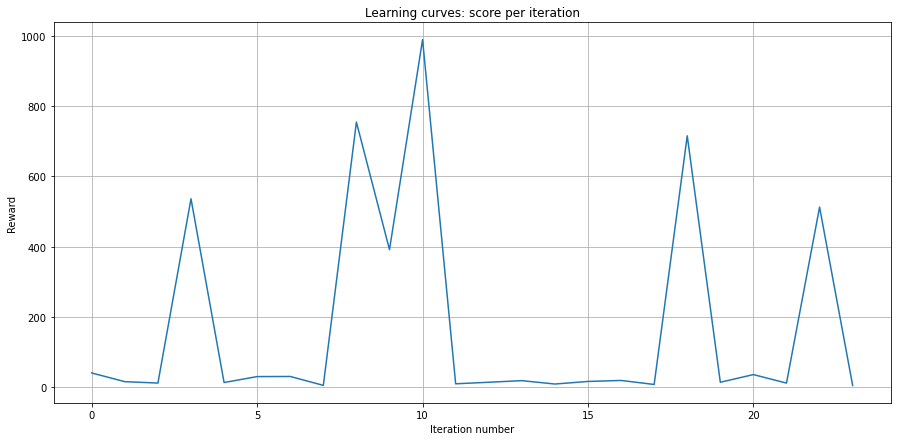

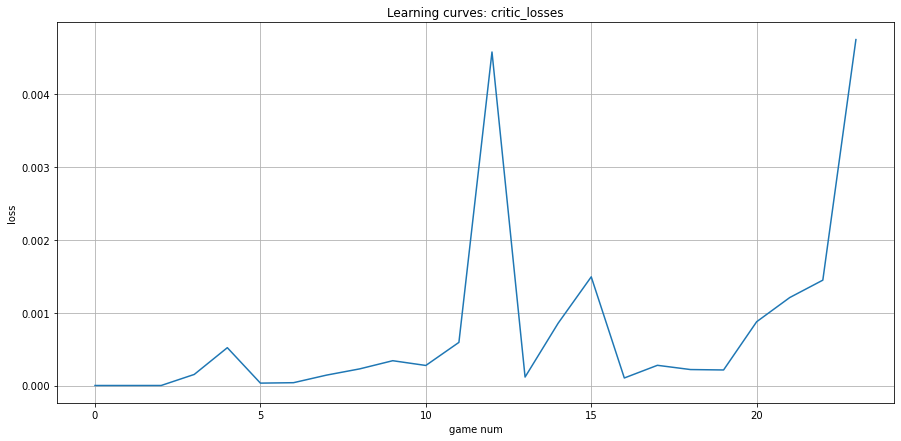

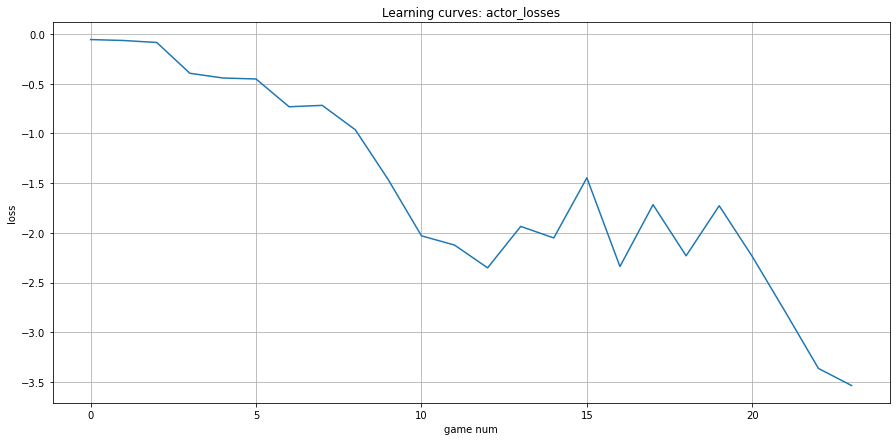

    25.668 minutes remaining


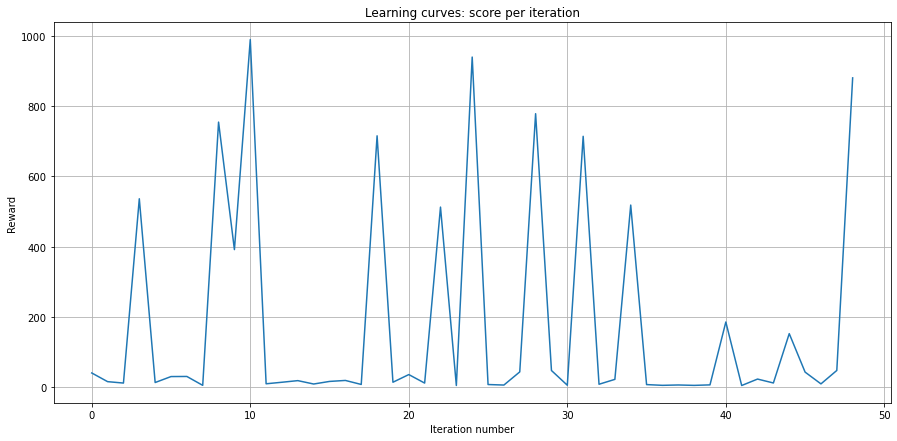

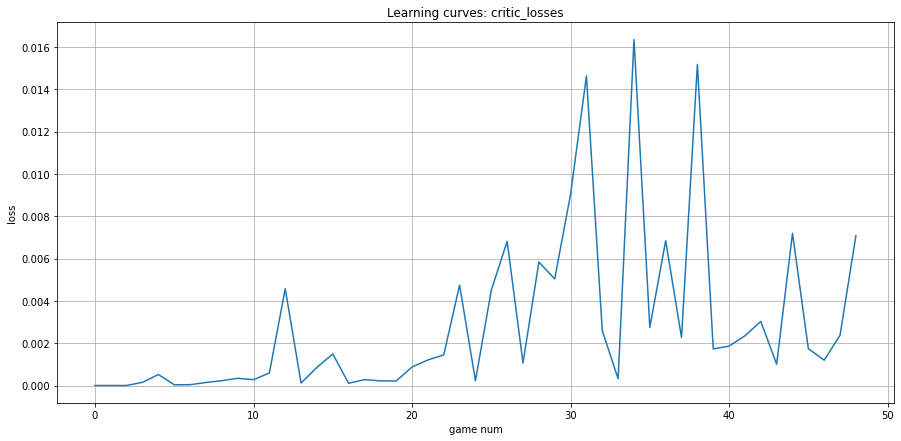

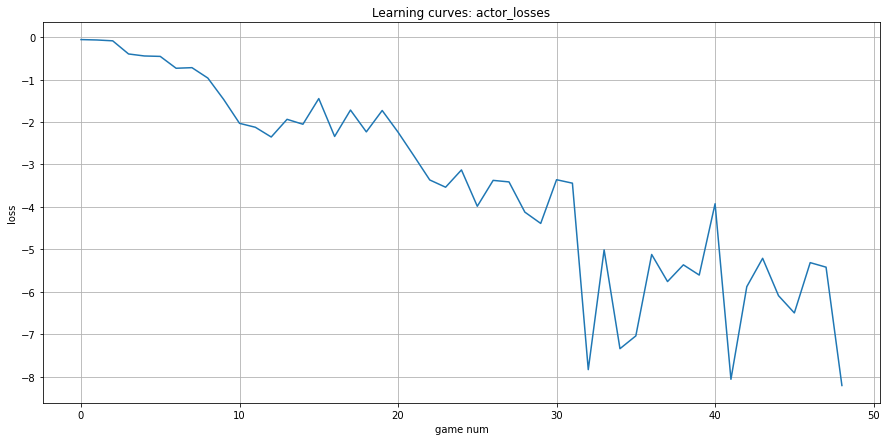

    56.032 minutes remaining


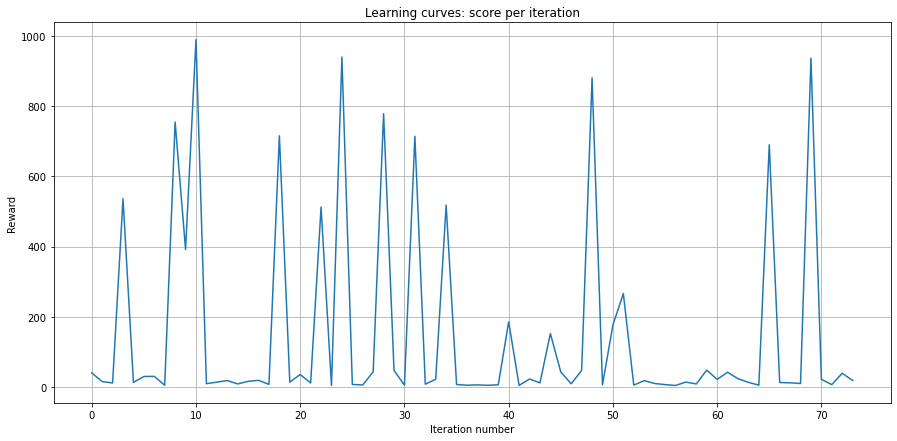

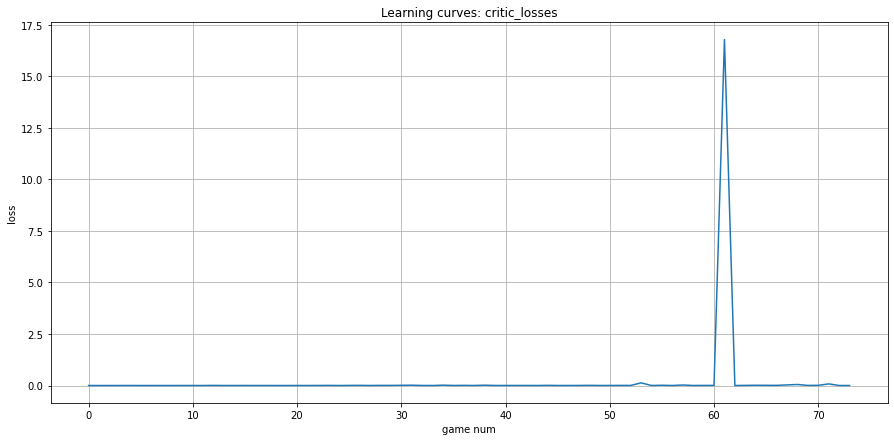

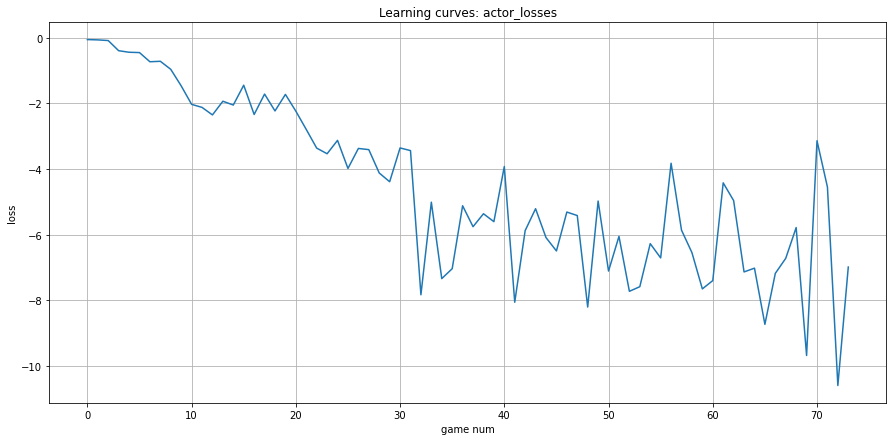

    93.872 minutes remaining


In [ ]:
n_iterations = 500
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

scores, last_rewards, first_rewards, agent = train_model(env, n_iterations, batch_size=64, discount_rate=0.99)

In [ ]:
better_arr = np.array((last_rewards[-100:] - first_rewards[-100:])>0, dtype = int)
plt.figure(figsize=(10,7))
better_results = np.sum(better_arr)
plt.bar([0, 1],[len(better_arr)-better_results, better_results], 0.3)
plt.xticks([0,1],labels = ["False", "True"])
plt.title("Learning curves: is the last point is closer to the target than the first point")
plt.ylabel("Amount")
plt.xlabel("Is closer")
plt.savefig("closer_points.png")
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

In [ ]:
for i in range(1,2):
    print(i,"Average learning score on 100 steps: ", np.mean(scores[(i-1)*100: i*100]))

In [ ]:
test_games = 100

test_scores = []
test_last_rewards = []
for game_index in range(test_games):
    score = 0
    time_step = env.reset()  
    obs = convert_observation(time_step.observation)
    while not time_step.last(): 
        action = agent.target_actor_model.predict(obs)
        time_step = env.step(action[0])
        obs = convert_observation(time_step.observation)
        score += time_step.reward

    test_scores.append(score)
    test_last_rewards.append(time_step.reward)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Reward on test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Rewards on the last step on test 100 games')
ax.boxplot(test_last_rewards,   
          showfliers=True)

ax.set_ylabel("Reward on the last step")
plt.savefig("last_rewards.png")
plt.show()